In [12]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Firebase initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['44444']
ACTIVITIES = ['sit', 'walk', 'upstairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DIFF_THRESHOLD = 35

In [13]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)
    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()
            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [14]:
class CNNClassifier(nn.Module):
    def __init__(self, input_channels=6, nclasses=len(ACTIVITIES)):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (CHUNK_SIZE * SAMPLING_RATE // 2), 128)
        self.fc2 = nn.Linear(128, nclasses)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [15]:
def train_and_evaluate_before_after():
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_train_full, y_train_full = chunk_data_raw(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_test_np, y_test_np = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    device = torch.device('cpu')
    model = CNNClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Testing
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_correct += (preds.argmax(dim=1) == yb).sum().item()
            test_total += yb.size(0)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    test_acc = test_correct / test_total * 100
    print(f"\nTest Accuracy (AfterTreatment): {test_acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('CNN Test Confusion Matrix')
    plt.show()

    acc_diff = abs(train_acc - test_acc)
    if acc_diff >= DIFF_THRESHOLD:
        print(f"Train-Test accuracy differs by {acc_diff:.2f}%, exceeds threshold. Data is different before vs after.")
    else:
        print(f"Train-Test accuracy differs by only {acc_diff:.2f}%, within threshold. Data is similar before vs after.")

Epoch 1/100 | Train Acc: 36.52% | Val Acc: 65.52%
Epoch 2/100 | Train Acc: 66.96% | Val Acc: 68.97%
Epoch 3/100 | Train Acc: 66.96% | Val Acc: 68.97%
Epoch 4/100 | Train Acc: 75.65% | Val Acc: 65.52%
Epoch 5/100 | Train Acc: 71.30% | Val Acc: 58.62%
Epoch 6/100 | Train Acc: 86.96% | Val Acc: 68.97%
Epoch 7/100 | Train Acc: 75.65% | Val Acc: 68.97%
Epoch 8/100 | Train Acc: 86.96% | Val Acc: 65.52%
Epoch 9/100 | Train Acc: 80.87% | Val Acc: 68.97%
Epoch 10/100 | Train Acc: 86.96% | Val Acc: 79.31%
Epoch 11/100 | Train Acc: 90.43% | Val Acc: 75.86%
Epoch 12/100 | Train Acc: 87.83% | Val Acc: 79.31%
Epoch 13/100 | Train Acc: 91.30% | Val Acc: 79.31%
Epoch 14/100 | Train Acc: 84.35% | Val Acc: 82.76%
Epoch 15/100 | Train Acc: 88.70% | Val Acc: 79.31%
Epoch 16/100 | Train Acc: 89.57% | Val Acc: 79.31%
Epoch 17/100 | Train Acc: 96.52% | Val Acc: 89.66%
Epoch 18/100 | Train Acc: 97.39% | Val Acc: 89.66%
Epoch 19/100 | Train Acc: 93.04% | Val Acc: 89.66%
Epoch 20/100 | Train Acc: 99.13% | Val A

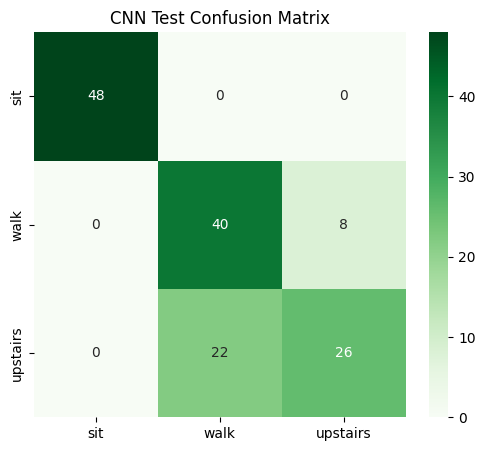

Train-Test accuracy differs by only 20.83%, within threshold. Data is similar before vs after.


In [16]:
if __name__ == "__main__":
    train_and_evaluate_before_after()